## What is Principal Components Analysis (PCA)?

PCA is a complexity-reduction technique that tries to reduce a set of variables down to a smaller set of components that represent most of the information in the variables.  At a conceptual level, PCA works by identifying sets of variables that share variance, and creating a component to represent that variance.  For example, the two images below represent the two different ways of sharing variance across three variables.  In each, overlapping areas represent shared variance.  

<img src = "pca_pic.png"/>
A PCA of set A would probably result in one component representing the variance shared by all three, discarding the rest of the information in the circles.  A PCA of set B, on the other hand, would probably result in two components, one representing the overlapping area shared by magenta and cyan, and one representing the variance in yellow not already included in the magenta/cyan component.  In both cases, some variance is lost.

Losing variance in exchange for a smaller set of features can be worthwhile. Some model types (such as regression) assume that features will be uncorrelated with each other, and high levels of inter-feature correlation create unstable solutions. Solutions with fewer features are easier to understand and are more computationally efficient. Solutions with fewer features are also less vulnerable to overfitting.


## Things Get Messy

PCA works best for normally-distributed data and assumes the relationships among variables are linear.  PCA also works best when the variables involved range from weakly correlated to moderately strongly correlated.  Correlations of 0, or correlations greater than .7 or .8, create problems.  Correlations near 0 mean there is no shared information.  Correlations that are too high can result in components that are unstable and change a lot in response to very small changes in the data, or components that are made up of variance from only one or two variables.  A few very high or very low correlations are fine.  It’s when we have a variable that mostly has very high or very low correlations with other variables that problems can occur.

## PCA: Rotation in space
Picture a dataset of *n* variables as an n-dimensional space.  This is a generalization of the two-dimensional scatterplot we are familiar with, which represents two variables in a two-dimensional space.  In PCA, the variables are first standardized to have a mean of 0 and standard deviation of 1.  This is important because now all variables go through the origin point (where the value of all axes is 0) and share the same variance.  Next, the axes of the n-dimensional space are rotated to minimize the distance between the datapoints and the axes.  

During rotation, some axes become shorter, indicating that variance along that axis is small and the axis contains little information.  That axis, and the principal component it represents, can be dropped without much loss of information.

Below is a demonstration of the role of rotation in PCA in a two-dimensional space:


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from matplotlib.mlab import PCA as mlabPCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA 

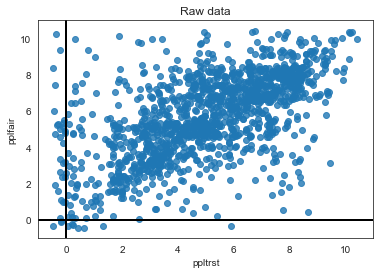

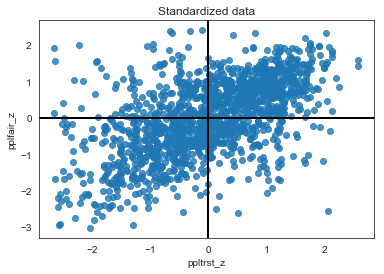

<class 'matplotlib.axes._subplots.AxesSubplot'>


In [5]:
# Make the scatterplot matrix.

# Setting the default plot aesthetics to be prettier.
sns.set_style("white")

df = pd.read_csv('https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/master/ESS_practice_data/ESSdata_Thinkful.csv')

# Take a subset of the data for PCA. This limits to Swiss and Czech data from 2012
# and keeps only specific columns.
df_pca = df.loc[
    ((df['cntry'] == 'CZ') | (df['cntry'] == 'CH')) & (df['year'] == 6),
    ['tvtot','ppltrst','pplfair','pplhlp']
].dropna()

t = sns.regplot(
    'ppltrst',
    'pplfair',
    df_pca,
    x_jitter=.49,
    y_jitter=.49,
    fit_reg=False
)
t.set(xlim=(-1, 11), ylim=(-1, 11))
t.axhline(0, color='k', linestyle='-', linewidth=2)
t.axvline(0, color='k', linestyle='-', linewidth=2)
t.axes.set_title('Raw data')
plt.show()

# Standardizing variables by subtracting the mean and dividing by the standard
# deviation. Now both variables are on the same scale.
df_pca['ppltrst_z'] = (df_pca['ppltrst'] - df_pca['ppltrst'].mean()) / df_pca['ppltrst'].std()
df_pca['pplfair_z'] = (df_pca['pplfair'] - df_pca['pplfair'].mean()) / df_pca['pplfair'].std()

t = sns.regplot(
    'ppltrst_z',
    'pplfair_z',
    df_pca,
    x_jitter=.49,
    y_jitter=.49,
    fit_reg=False
)
t.axhline(0, color='k', linestyle='-', linewidth=2)
t.axvline(0, color='k', linestyle='-', linewidth=2)
t.axes.set_title('Standardized data')
plt.show()
print(type(t))


In the plot above, both axes describe equal variance- they both run from about -3 to 2.5.  If we were to drop one of the axes and describe the data using only the information from the other axis, we would lose roughly 50% of our information. 

However, if we fit a line through the origin that minimizes the distance between the line and each point and then rotate the data, our axes and their information value will change.

<IMG SRC='assets/pca_vector.png'>



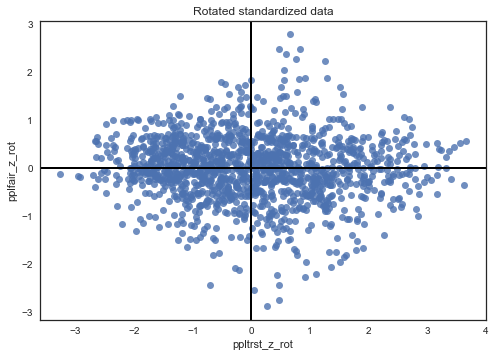

In [5]:
# Rotating the data so that the axes roughly match to vector above.
df_pca['ppltrst_z_rot'] = math.cos(40) * df_pca['ppltrst_z'] - math.sin(40) * df_pca['pplfair_z']
df_pca['pplfair_z_rot'] = math.sin(40) * df_pca['ppltrst_z'] + math.cos(40) * df_pca['pplfair_z']

t = sns.regplot(
    'ppltrst_z_rot',
    'pplfair_z_rot',
    df_pca,
    x_jitter=.49,
    y_jitter=.49,
    fit_reg=False
)
t.axhline(0, color='k', linestyle='-', linewidth=2)
t.axvline(0, color='k', linestyle='-', linewidth=2)
t.axes.set_title('Rotated standardized data')
plt.show()


In the image above, the horizontal vector is longer than the vertical vector, spanning from -3.5 to 4 rather than -3 to 2.5. The horizontal axis therefore contains more variance, and has a higher information value, than the vertical vector.  If we treated the axes as principal components and discarded the vertical vector, each datapoint would be described solely by its position on the horizontal axis.  The information on each datapoint's vertical position would be lost.  Because of the rotation, if we drop the vertical axis now, we lose _less_ than 50% of the information.

A significant part of doing PCA is deciding whether the gain from dropping a component from the feature pool is worth the loss of information.


## The Math Behind PCA
The "rotation" pictured above is based on calculating the covariance matrix of the data and applying a linear transformation (rotation) and deriving from that the eigenvalues and eigenvectors that express the amount of variance in the data explained by the new axes.  To explore this further, let's delve into some linear algebra.

## Covariance matrix
A correlation matrix, which we have discussed before, is a covariance matrix where the covariances have been divided by the variances.  This standardizes the covariances so that they are all on the same scale (-1 to 1) and can be compared.  Covariance matrices, like correlation matrices, contain information about the amount of variance shared between pairs of variables.

The variance of x is the sum of the squared differences between each value in x ($x_i$) and the mean of x ($\bar{x}$), divided by the sample size (*n*).

$$var(x)=\frac{\sum(x_i-\bar{x})^2}n$$

(Note that the standard deviation is $\sqrt{var(x)}$)

The covariance between two variables x and y is the product of the differences of each variable value and its mean, divided by the sample size.

$$cov(A)=\sum\frac{(x_i-\bar{x})(y_i-\bar{y})}n$$

Here is the covariance matrix for the ESS data:

In [6]:
# Take a subset of the data for PCA and drop missing values because PCA cannot
# handle them. We could also impute, but missingness is quite low so dropping
# missing rows is unlikely to create bias.
df_pca = df.loc[
    ((df['cntry'] == 'CZ') | (df['cntry'] == 'CH')) & (df['year']==6),
    ['tvtot','ppltrst','pplfair','pplhlp']
].dropna()

# Normalize the data so that all variables have a mean of 0 and standard deviation
# of 1.
X = StandardScaler().fit_transform(df_pca)

# The NumPy covariance function assumes that variables are represented by rows,
# not columns, so we transpose X.
Xt = X.T
Cx = np.cov(Xt)
print('Covariance Matrix:\n', Cx)

Covariance Matrix:
 [[ 1.00071174 -0.24535312 -0.23531159 -0.17820482]
 [-0.24535312  1.00071174  0.60528939  0.49609931]
 [-0.23531159  0.60528939  1.00071174  0.53193085]
 [-0.17820482  0.49609931  0.53193085  1.00071174]]


## Data as a matrix
PCA deals with many variables at once, and represents those variables in formulas as a matrix with *m* rows and *n* columns, where each row represents a measurement instance (say, data from one participant over many variables) and each column represents a variable.  The mathematical convention is that matrices are referred to in capital letters.  For example, a dataset with 3 variables and 4 participants would be expressed as a 4 x 3 matrix *X* (notice that the rows come first, then the columns – just like when slicing a data frame, list, or string in Python).

$$\mathbf{X} = \left[\begin{array}
{rrr}
1 & 2 & 3 \\
2 & 3 & 6 \\
2 & 1 & 9 \\
4 & 5 & 1 
\end{array}\right]
$$

Matrices behave differently than individual variables in many ways.  In particular, multiplying two matrices together doesn't behave at all like multiplying two numbers!  If you're not familiar with matrix multiplication, take a step over here and read [this brief primer](https://www.mathsisfun.com/algebra/matrix-multiplying.html).

Because of the way matrix multiplication works, we can express the covariance matrix for *X* as the product of $X$ and the transpose of X ($X^T$).  A matrix is transposed by flipping it on its diagonal so that the row and column indices are switched. Here is the transpose of the $X$ matrix above:

$$\mathbf{X^T} = \left[\begin{array}
{rrr}
1 & 2 & 2 & 4\\
2 & 3 & 1 & 5\\
3 & 6& 9 & 1
\end{array}\right]
$$

The covariance matrix for $X$, by the logic of matrix multiplication, is therefore an *m* by *m* matrix where the diagonal terms represent the variance of each variable and the off-diagonals are the covariances. We represent the covariance matrix of $X$ as $C_X$:

$$\mathbf{C_X}=\frac1{n-1}XX^T$$

Look back at the covariance matrix for the ESS data.  It was created by multiplying a matrix of data with dimensions 1406 x 4 (1406 rows and 4 variables) by the transpose of that matrix, with dimensions 4 x 1406.  The covariance matrix, as a result, has dimensions 4 x 4.

## Back to PCA

In PCA, the goal is to transform the covariance matrix so that all the information is in the diagonals (variances) and none is in the off-diagonals (covariances).  We do this by finding a matrix $P$ where when we multiply $P$ and $X$ we get a matrix $Y$ with a covariance matrix $C_Y$ with only 0s on the off-diagonals.  

Starting with the formula for the covariance of $Y$:

$$\mathbf{C_Y}=\frac1{n-1}YY^T$$

We substitute $Y=PX$:
$$\mathbf{C_Y}=\frac1{n-1}(PX)(PX)^T$$
$$\mathbf{C_Y}=\frac1{n-1}PXX^TP^T$$

And finally break it down into something familiar.  Remember that $C_X=XX^T$:
$$\mathbf{C_Y}=\frac1{n-1}P(XX^T)P^T$$

What is $P$? $P$ is a matrix where each row is an eigenvector of $XX^T$.  Clear as mud, right?  Let's talk eigens.

## Eigenvectors
An Eigenvector is the directional aspect of a component – it is the red line in the graph earlier.  During PCA, the eigenvectors are chosen to be orthogonal, that is, to have a correlation of 0 with one another.  In fact, this is done sequentially.  First, a vector is found that minimizes the distance between that vector and the datapoints. This vector is the first component. Next, a second vector is found that also minimizes the distance between that vector and the datapoints, the catch being that this second vector must be perpendicular to the first in one of the n dimensions of the space. This procedure continues until there are n vectors.

## Eigenvalues
Eigenvalues represent the length of the Eigenvectors – each eigenvector has an eigenvalue.  The length of the eigenvector encodes the proportion of total variance explained by a component.  The total variance is equal to the number of variables in the PCA.  Thus, an Eigenvalue of 1 means that the component explains the same amount of variance as one variable.  An eigenvalue greater than 1 is desirable, since a component with an eigenvalue of 1 adds no value beyond the information contained in any individual variable, and an eigenvalue of less than 1 is actually less efficient at conveying information than a variable by itself.  An eigenvalue of 2 means that the component contains an amount of information equal to that of two variables.  Of course, it doesn’t mean that only two variables load on that component.

The proportion of the variance that each eigenvector represents can be calculated by dividing the eigenvalue corresponding to that eigenvector by the sum of all eigenvalues.

Here are the eigenvectors, eigenvalues, and variance explained for the ESS data:

In [7]:
# Calculating eigenvalues and eigenvectors.
eig_val_cov, eig_vec_cov = np.linalg.eig(Cx)

# Inspecting the eigenvalues and eigenvectors.
for i in range(len(eig_val_cov)):
    eigvec_cov = eig_vec_cov[:, i].reshape(1, 4).T
    print('Eigenvector {}: \n{}'.format(i + 1, eigvec_cov))
    print('Eigenvalue {}: {}'.format(i + 1, eig_val_cov[i]))
    print(40 * '-')

print(
    'The percentage of total variance in the dataset explained by each',
    'component calculated by hand.\n',
    eig_val_cov / sum(eig_val_cov)
)

Eigenvector 1: 
[[-0.30084526]
 [ 0.55945823]
 [ 0.5681188 ]
 [ 0.52320135]]
Eigenvalue 1: 2.2112568631998224
----------------------------------------
Eigenvector 2: 
[[ 0.94786152]
 [ 0.11600843]
 [ 0.15403897]
 [ 0.25371751]]
Eigenvalue 2: 0.8847413570711706
----------------------------------------
Eigenvector 3: 
[[ 0.10491426]
 [ 0.51597659]
 [ 0.28505945]
 [-0.80093836]]
Eigenvalue 3: 0.515142138923689
----------------------------------------
Eigenvector 4: 
[[ 0.00660771]
 [ 0.63821367]
 [-0.75647481]
 [ 0.14277786]]
Eigenvalue 4: 0.39170661589428524
----------------------------------------
The percentage of total variance in the dataset explained by each component calculated by hand.
 [ 0.55242103  0.22102802  0.12869394  0.097857  ]


## Components
Components are eigenvectors that have been divided by the square root of the eigenvalues.  This standardizes the components so that the amount of variance in each variable explained by a component can be compared across components.  For our data-reduction purposes, components will replace the factored variables, as all the components of a given solution, together, represent all the shared variance of the variables.  The benefit of PCA is that there will be fewer components than variables, thus simplifying the data space.  After PCA, we can use the components in any analysis exactly as we would use variables.

We can use the eigenvectors and covariance matrix from ESS to calculate the components, but first we have a decision to make.

## How many components?
The biggest decision to make when running a PCA is how many components to keep.  PCA will actually give us back as many components as there are variables in the correlation matrix.  If we have n variables and choose to keep n components, we will be able to reproduce 100% of the information in the original data.  On the other hand, we won’t have simplified our situation at all – we’ll still be dealing with the same number of separate pieces of information, just expressed as components instead of as variables.

There are a number of rules to guide us in choosing the number of components to keep.  The most straightforward is to keep components with eigenvalues greater than 1, as they add value (because they contain more information than a single variable).  This rule tends to keep more components than is ideal.

Another rule is to visualize the eigenvalues in order from highest to lowest, connecting them with a line. This is called a "scree" plot because it supposedly resembles the loose rock that accumulates at the foot of a mountain.  Upon visual inspection, the analyst will keep all the components whose eigenvalue falls above the point where the slope of the line changes the most drastically, also called the "elbow".  

Many other rules also exist, including variance cutoffs where we only keep components that explain at least x% of the variance in the data, and programmatic ones involving simulating the PCA solution on equivalent randomized data.  Ultimately, the choice of how many components to keep comes down to your reasons for doing PCA.

Let's see how many components we should keep in the ESS data:

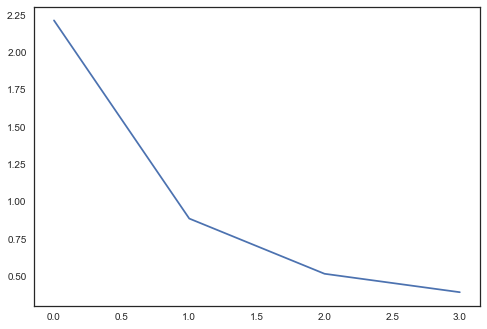

In [8]:
plt.plot(eig_val_cov)
plt.show()

The scree plot and the eigenvalues >1 rule agree that we should keep only the first component.  Now it's time to create P, transform X into Y, and look at how well our new component correlates with our old variables.

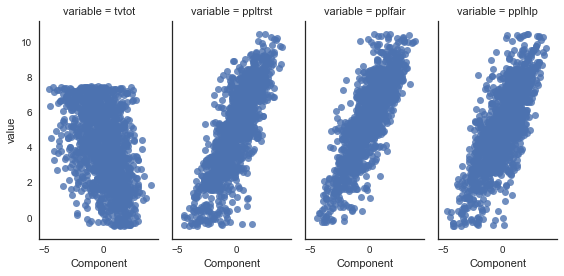

In [9]:
# Create P, which we will use to transform Cx into Cy to get Y, the
# dimensionally-reduced representation of X.
P = eig_vec_cov[:, 0]

# Transform X into Y.
Y = P.T.dot(Xt)

# Combine X and Y for plotting purposes.
data_to_plot = df_pca[['tvtot', 'ppltrst', 'pplfair', 'pplhlp']]
data_to_plot['Component'] = Y
data_to_plot = pd.melt(data_to_plot, id_vars='Component')

g = sns.FacetGrid(data_to_plot, col="variable", size=4, aspect=.5)
g = g.map(
    sns.regplot,
    "Component",
    "value",
    x_jitter=.49,
    y_jitter=.49,
    fit_reg=False
)
plt.show()

Ultimately we have a solution that encompasses over 55% of the variance in the data in just one component, rather than four variables.

While we rolled this PCA by hand for learning purposes, there are PCA functions in both matplotlib and scikit-learn that will do it all for you:

The percentage of total variance in the dataset explained by each component from Sklearn PCA.
 [ 0.55242103  0.22102802  0.12869394  0.097857  ]


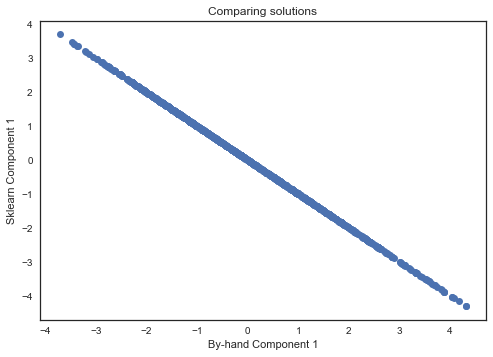

In [10]:
sklearn_pca = PCA(n_components=4)
Y_sklearn = sklearn_pca.fit_transform(X)

print(
    'The percentage of total variance in the dataset explained by each',
    'component from Sklearn PCA.\n',
    sklearn_pca.explained_variance_ratio_
)

# Compare the sklearn solution to ours – a perfect match.
plt.plot(Y_sklearn[:, 0], Y, 'o')
plt.title('Comparing solutions')
plt.ylabel('Sklearn Component 1')
plt.xlabel('By-hand Component 1')
plt.show()

There are other ways to calculate PCA besides the covariance-based approach presented here. For example, Singular Value Decomposition is popular.  For a deep dive into the mathematics of PCA, check out [A Tutorial on Principal Component Analysis](https://www.ics.forth.gr/mobile/pca.pdf) by Jonathon Shlens at the Salk Institute.

## Summary

PCA is a series of linear transformations applied to a data frame to yield a smaller number of columns that explain a large proportion of the total variance contained in the data frame.  PCA works by first transforming the data $X$ into a covariance matrix $C_X$.  Then a set of eigenvectors $P$ is calculated that, when combined with $C_X$ through multiplication ($PC_XP^T$), create a new covariance matrix $C_Y$ with zeros on the off-diagonal elements.  We then take $P$, choose the eigenvectors corresponding to the most variance explained ($P_{var}$), and use it to transform the original data $X$ (via $P_{var}X$) into $Y$, a new simplified dataset with as many columns as eigenvectors in ($P_{var}$).